<a href="https://colab.research.google.com/github/tanishq20011430/collage/blob/main/stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%%**********************]  1 of 1 completed
Epoch 1/100
12/12 [==============================] - 17s 649ms/step - loss: 0.0156 - val_loss: 0.0781
Epoch 2/100
12/12 [==============================] - 7s 584ms/step - loss: 0.0034 - val_loss: 0.0151
Epoch 3/100
12/12 [==============================] - 4s 340ms/step - loss: 0.0019 - val_loss: 0.0147
Epoch 4/100
12/12 [==============================] - 3s 215ms/step - loss: 0.0011 - val_loss: 0.0042
Epoch 5/100
12/12 [==============================] - 5s 404ms/step - loss: 9.6312e-04 - val_loss: 0.0022
Epoch 6/100
12/12 [==============================] - 3s 212ms/step - loss: 9.1220e-04 - val_loss: 0.0023
Epoch 7/100
12/12 [==============================] - 3s 213ms/step - loss: 9.0776e-04 - val_loss: 0.0029
Epoch 8/100
12/12 [==============================] - 3s 218ms/step - loss: 8.9324e-04 - val_loss: 0.0015
Epoch 9/100
12/12 [==============================] - 4s 336ms/step - loss: 8.6244e-04 - val_loss: 0.0018
E

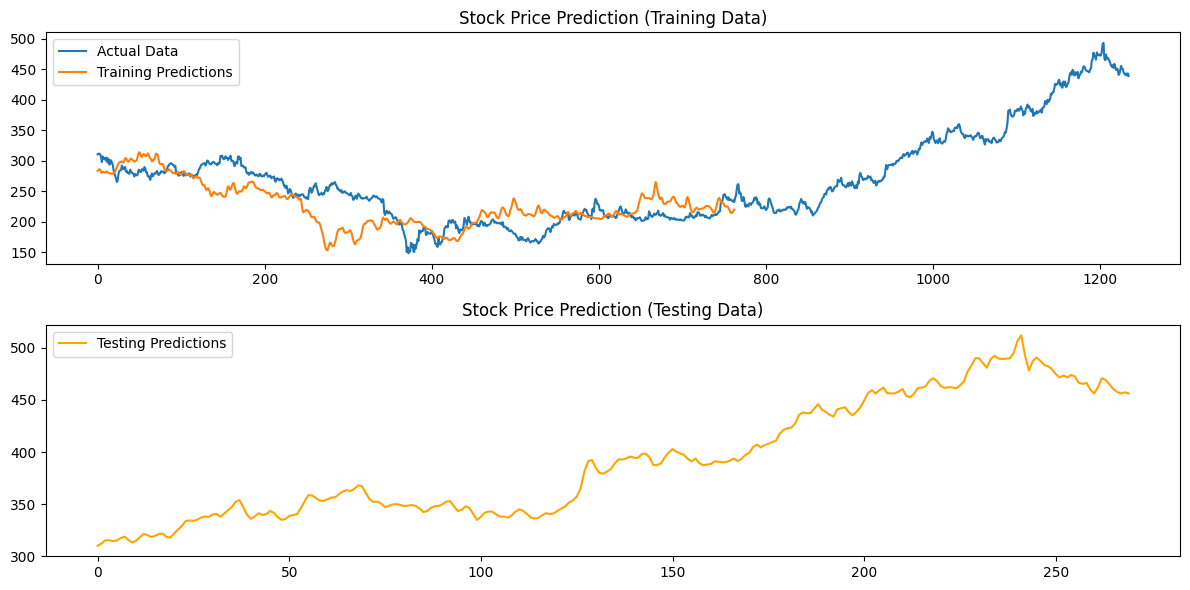

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Define constants
stock_symbol = 'ITC.NS'
time_stamp = 100
epochs = 100
batch_size = 64

# Function to load stock data
def load_stock_data(stock_symbol):
    try:
        data = yf.download(tickers=stock_symbol, period='5y', interval='1d')
        opn = data[['Open']]
        ds = opn.values
        return ds
    except Exception as e:
        print(f"Error loading stock data: {str(e)}")
        raise

# Function to normalize data
def normalize_data(ds):
    try:
        normalizer = MinMaxScaler(feature_range=(0, 1))
        ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1, 1))
        return ds_scaled, normalizer
    except Exception as e:
        print(f"Error normalizing data: {str(e)}")
        raise

# Function to split data into train and test sets
def split_data(ds_scaled):
    try:
        train_size = int(len(ds_scaled) * 0.70)
        ds_train, ds_test = ds_scaled[0:train_size], ds_scaled[train_size:len(ds_scaled), :1]
        return ds_train, ds_test
    except Exception as e:
        print(f"Error splitting data: {str(e)}")
        raise

# Function to create time series dataset
def create_time_series(dataset, step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset) - step - 1):
        a = dataset[i:(i + step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

# Function to build LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(LSTM(units=50))
    model.add(Dense(units=1, activation='linear'))
    return model

# Function to train the model
def train_model(model, x_train, y_train, x_test, y_test):
    try:
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=batch_size)
        return model
    except Exception as e:
        print(f"Error training the model: {str(e)}")
        raise

# Main function
def main():
    try:
        # Load and preprocess data
        ds = load_stock_data(stock_symbol)
        ds_scaled, normalizer = normalize_data(ds)
        ds_train, ds_test = split_data(ds_scaled)

        # Create time series datasets
        x_train, y_train = create_time_series(ds_train, time_stamp)
        x_test, y_test = create_time_series(ds_test, time_stamp)

        # Reshape data for LSTM
        input_shape = (x_train.shape[1], 1)
        x_train = x_train.reshape(x_train.shape[0], *input_shape)
        x_test = x_test.reshape(x_test.shape[0], *input_shape)

        # Build and train LSTM model
        model = build_lstm_model(input_shape)
        trained_model = train_model(model, x_train, y_train, x_test, y_test)

        # Predict on train and test data
        train_predict = trained_model.predict(x_train)
        test_predict = trained_model.predict(x_test)

        # Inverse transform to get actual values
        train_predict = normalizer.inverse_transform(train_predict)
        test_predict = normalizer.inverse_transform(test_predict)

        # Plot the results
        plt.figure(figsize=(12, 6))
        plt.subplot(2, 1, 1)
        plt.plot(normalizer.inverse_transform(ds_scaled), label='Actual Data')
        plt.plot(train_predict, label='Training Predictions')
        plt.title('Stock Price Prediction (Training Data)')
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(test_predict, label='Testing Predictions', color='orange')
        plt.title('Stock Price Prediction (Testing Data)')
        plt.legend()

        # Save the plot as an image
        plt.tight_layout()
        plt.savefig('stock_prediction_plot.png')

        # Display the plot
        plt.show()

    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()
